In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [2]:
plt.rcParams['font.size'] = 8
plt.rc('font', size=10) 

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
encoded_df = pd.read_pickle('../data/encoded_df.pkl')
encoded_df.head()

,I identify as having a mental illness,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total gaps in resume in months,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,Lack of concentration,Anxiety,Depression,Obsessive_thinking,Mood_swings,Panic_attacks,Compulsive_behavior,Tiredness,Education_Completed Masters,Education_Completed Phd,Education_Completed Undergraduate,Education_High School or GED,Education_Some Phd,Education_Some Undergraduate,Education_Some highschool,Education_Some Masters,Age_18-29,Age_30-44,Age_45-60,Age_> 60,Gender_Female,Gender_Male,"Household Income_$0-$9,999","Household Income_$10,000-$24,999","Household Income_$100,000-$124,999","Household Income_$125,000-$149,999","Household Income_$150,000-$174,999","Household Income_$175,000-$199,999","Household Income_$200,000+","Household Income_$25,000-$49,999","Household Income_$50,000-$74,999","Household Income_$75,000-$99,999",Household Income_Prefer not to answer,Region_East North Central,Region_East South Central,Region_Middle Atlantic,Region_Mountain,Region_New England,Region_Pacific,Region_South Atlantic,Region_West North Central,Region_West South Central,Device Type_Android Phone / Tablet,Device Type_MacOS Desktop / Laptop,Device Type_Other,Device Type_Windows Desktop / Laptop,Device Type_iOS Phone / Tablet,time_to_complete
0,0,0,0,0,0,1,0,1,24,35,1,1,0,0,0,0,1,1,1,1,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,188.0
1,1,1,0,0,0,1,0,0,1,22,0,1,0,0,0,0,1,1,1,0,0,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,65.0
2,0,1,0,0,0,1,0,0,0,100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,141.0
3,0,1,0,0,0,1,1,1,11,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,77.0
4,1,1,1,35,1,1,0,1,33,32,0,1,30,0,0,4,1,1,1,1,1,1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,142.0


# Modeling

## Question: Can we predict unemployment from mental health data?
### Target: 'I am unemployed'

#### V1 - using all features in cleaned df

###### Notes:
Stratify the train-test split to ensure even distribution of classes between the splits

In [4]:
random_seed = 13

y = encoded_df['I am unemployed']
X = encoded_df.drop('I am unemployed', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=random_seed, stratify=y)

In [5]:
def score_fitted_model(model, X_test, y_test, file_name=None, title=None):
    target_labels = ['Employed', 'Unemployed']
    
    y_hat = model.predict(X_test)
    
    score_types = {'Accuracy':accuracy_score,'Precision':precision_score, 'Recall':recall_score, 'F1':f1_score}
    
    for metric_name, metric_func in score_types.items():
        print(f'{metric_name}: {round(metric_func(y_test, y_hat),2)}')
    
    fig, ax = plt.subplots(figsize=(4,4))
    if title: 
        ax.set_title(title)
        
    plot_confusion_matrix(model, X_test, y_test, display_labels=target_labels, ax=ax)
    if file_name:
        plt.savefig(f'../img/{file_name}.png', bbox_inches="tight")
    plt.show()
    
    #print(classification_report(y_true=y_test, y_pred=y_hat, target_names=target_labels))

### Logistic Regression Model

Accuracy: 0.75
Precision: 0.5
Recall: 0.41
F1: 0.45


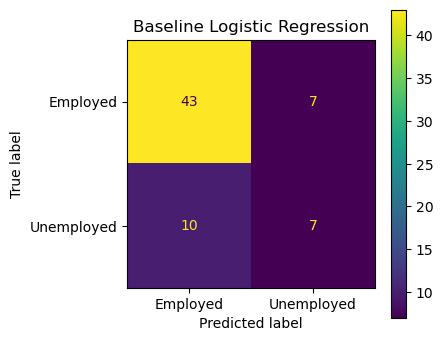

In [7]:
lr = LogisticRegression()
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr.fit(X_train_scaled, y_train)

score_fitted_model(lr, X_test_scaled, y_test, file_name='conf_mat_baseline_log_reg', title='Baseline Logistic Regression')

### RandomForest

Accuracy: 0.73
Precision: 0.43
Recall: 0.18
F1: 0.25


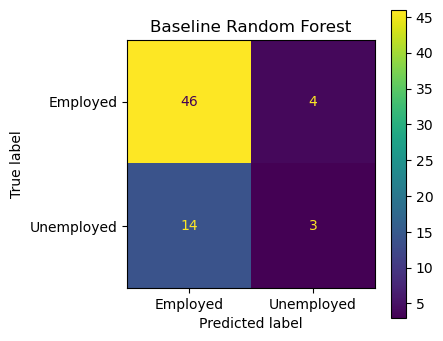

In [8]:
rf_clf = RandomForestClassifier(random_state=random_seed)
rf_clf.fit(X_train, y_train)

score_fitted_model(rf_clf, X_test, y_test, file_name='conf_mat_baseline_rand_for', title='Baseline Random Forest')

The top 20 features

In [9]:
pd.Series(index=X.columns, data=rf_clf.feature_importances_).sort_values(ascending=False)[:10]

Annual income (including any social welfare programs) in USD    0.084982
time_to_complete                                                0.077139
Total gaps in resume in months                                  0.072521
Annual income from social welfare programs                      0.041989
I am legally disabled                                           0.037107
I have a gap in my resume                                       0.029381
Household Income_$0-$9,999                                      0.025363
How many days were you hospitalized for your mental illness     0.024618
How many times were you hospitalized for your mental illness    0.022467
Household Income_$50,000-$74,999                                0.021020
dtype: float64

In [10]:
pd.DataFrame(index=X.columns, data=rf_clf.feature_importances_, columns=['importance']).sort_values(by='importance', ascending=False)[:10]

,importance
Annual income (including any social welfare programs) in USD,0.084982
time_to_complete,0.077139
Total gaps in resume in months,0.072521
Annual income from social welfare programs,0.041989
I am legally disabled,0.037107
I have a gap in my resume,0.029381
"Household Income_$0-$9,999",0.025363
How many days were you hospitalized for your mental illness,0.024618
How many times were you hospitalized for your mental illness,0.022467
"Household Income_$50,000-$74,999",0.021020


#### Interpreting results.
##### Accuracy and precision are pretty good, but the recall score is not. 
What is the best metric for this case? The cost of a false positive, i.e. predicting someone will become unemployed but they don't, is not likely a great concern, so precision is going to be primary.

On the other hand, a false negative of predicing a person won't become unemployed but does, would mostly likely be a case we would want to avoid the most. Therefore, recall is more important than precision or accuracy.

F1 is a balance of recall and precision. As expected it is somewhere inbetween the two, but it is most helpful in situations where there is a class imbalance and there are more actual negatives. This is the case with our data where we have about a 3:1 ratio of negative to positive target responses. So the F1 score may be the best score for our case.

First, let's use cross validation to see if these results hold up.

#### V2 - Hyperparameter Tuning with All Features in Data

In [11]:
def tune_model(X, y, pipe, params):
    gridsearch = GridSearchCV(estimator=pipe, param_grid=params, scoring='f1', verbose=2, n_jobs=-1).fit(X, y)
    print(f'Best F1 Score: {gridsearch.score(X, y)}')
    
    best_params = gridsearch.best_params_
    print(best_params)
    
    return gridsearch    

In [12]:
pipe_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', LogisticRegression(max_iter=600, random_state=random_seed))
])

# define parameter ranges in dict
# use double underscore to link pipline object with param name -
# - use the label created when defining the pipe for the test left of the '__'
params_lr = {
    'estimator__solver' : ['lbfgs','liblinear', 'saga'],
    'estimator__penalty' : ['l1','l2','elasticnet'],
    'estimator__class_weight' : ['balanced', None]
}

gridpipe_lr = tune_model(X_train_scaled, y_train, pipe_lr, params_lr)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    1.8s remaining:    0.4s


Best F1 Score: 0.7530864197530863
{'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.0s finished


Accuracy: 0.69
Precision: 0.41
Recall: 0.53
F1: 0.46


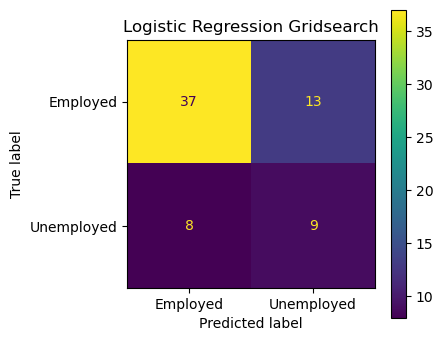

In [13]:
score_fitted_model(gridpipe_lr, X_test_scaled, y_test, file_name=None, title='Logistic Regression Gridsearch')

In [14]:
pipe_rf = Pipeline(steps=[
    ## RandomForests/Decision Trees don't benefit from scaling('scaler', StandardScaler()),
    ('estimator', RandomForestClassifier(random_state=random_seed))
])

# define parameter ranges in dict
# use double underscore to link pipline object with param name -
# - use the label created when defining the pipe for the test left of the '__'
params_rf = {
    'estimator__n_estimators' : np.arange(40, 111, 10),
    'estimator__max_depth' : np.arange(8, 20, 1),
    'estimator__max_features' : ['auto', 'sqrt', 'log2']
}

gridpipe_rf = tune_model(X_train, y_train, pipe_rf, params_rf)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   29.8s


Best F1 Score: 0.9465648854961832
{'estimator__max_depth': 11, 'estimator__max_features': 'log2', 'estimator__n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   34.5s finished


Accuracy: 0.75
Precision: 0.5
Recall: 0.12
F1: 0.19


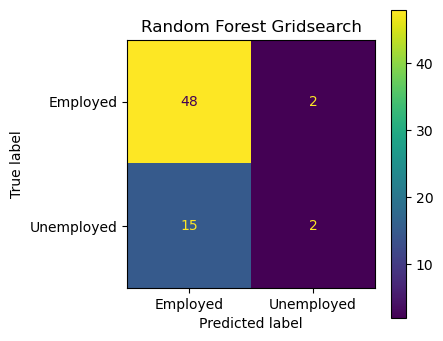

In [15]:
score_fitted_model(gridpipe_rf, X_test, y_test, title='Random Forest Gridsearch')

## Results So Far
The logistic regression is outperforming the RandomForest, which appears to be overfitting. Gridsearch improved recal for the Logistic Regression model by .12 and did not help improve the Random Forest.

Let's remove all income data because of possible colinearity.
And date data, device type and hospitalizations because of low correlation with target

In [16]:
drop_me = [
           'Annual income (including any social welfare programs) in USD',
           'Annual income from social welfare programs',
           'I have been hospitalized before for my mental illness', 
           'How many days were you hospitalized for your mental illness',
           'I have a gap in my resume'
          ]

In [17]:
X_reduced = X.drop(columns=drop_me)

In [18]:
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y, test_size = .2, random_state=random_seed, stratify=y)

Accuracy: 0.75
Precision: 0.5
Recall: 0.29
F1: 0.37


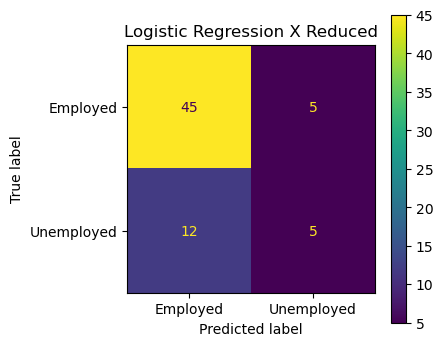

In [19]:
lr2 = LogisticRegression(random_state=random_seed)
scaler = StandardScaler()
X_train_red_scaled  = scaler.fit_transform(X_train_red)
X_test_red_scaled = scaler.transform(X_test_red)

lr2.fit(X_train_red_scaled, y_train_red)

score_fitted_model(lr2, X_test_red_scaled, y_test_red, title='Logistic Regression X Reduced')

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.2s


Best F1 Score: 0.7577639751552795
{'estimator__class_weight': 'balanced', 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
Accuracy: 0.7
Precision: 0.43
Recall: 0.53
F1: 0.47


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished


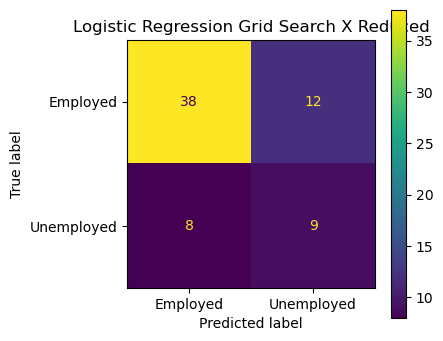

In [20]:
gridpipe_lr2 = tune_model(X_train_red_scaled, y_train_red, pipe_lr, params_lr)
score_fitted_model(gridpipe_lr2, X_test_red_scaled, y_test_red, title='Logistic Regression Grid Search X Reduced')

## V3 - Using Recusive Feature Elimination To Find Best Features

In [21]:
def plot_best_num_of_features(model, rfecv, rfe_scoring, base_filename):
    plt.figure(figsize=(8,4))
    plt.title(f'{model.__class__.__name__} Recusive Feature Elimination with CV Results' )
    plt.xlabel('Num of features selected', fontsize=12, labelpad=20)
    plt.ylabel(f'{rfe_scoring.capitalize()} Score',fontsize=12, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)
    plt.savefig(f'../img/{base_filename}_rfe_num_features.png', bbox_inches='tight')
    plt.show()
    
    print('Optimal number of features: {}'.format(rfecv.n_features_))

In [22]:
def get_top_rfe_features(X, rfecv):
    M = np.array([X.columns, rfecv.ranking_])
    df_rfe = pd.DataFrame(data=M.T, columns=['feature', 'ranking'])
    
    top_features = df_rfe[df_rfe['ranking']==1]
    display(top_features)
    
    X_most_imp = X[top_features['feature']].copy()
    
    return X_most_imp

In [33]:
def run_rfe(X, y, model, base_filename, rfe_scoring='f1', scale_features=False):
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10), scoring=rfe_scoring, n_jobs=-1)
    
    # this step is undesireable - scaling the entire X matrix will create data leakage - but I can't figure out how to scale within the RFECV process
    if scale_features:
        X2 = StandardScaler().fit_transform(X)
        rfecv.fit(X2, y)
    else:
        X2 = X.copy()
        
    rfecv.fit(X2, y)
    
    plot_best_num_of_features(model, rfecv, rfe_scoring, base_filename)
        
    # Here we use the original X data so that proper scaling can occur if needed
    X_most_imp = get_top_rfe_features(X, rfecv)
    
    X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_most_imp, y, test_size = .2, random_state=random_seed, stratify=y)

    if scale_features:
        scaler_rfe = StandardScaler()
        X_train_rfe  = scaler_rfe.fit_transform(X_train_rfe)
        X_test_rfe = scaler_rfe.transform(X_test_rfe)
        
    model.fit(X_train_rfe, y_train_rfe)
    print('Re-run the model with only the most important features of the same train-test split data used in the previous modeling so we can accurately compare the results.')
    print('')
    score_fitted_model(model, X_test_rfe, y_test_rfe, file_name=f'{base_filename}_conf_mat_rfe', title=f'{model.__class__.__name__} with RFECV')
    
    return X_most_imp.columns

### RFECV with Random Forest

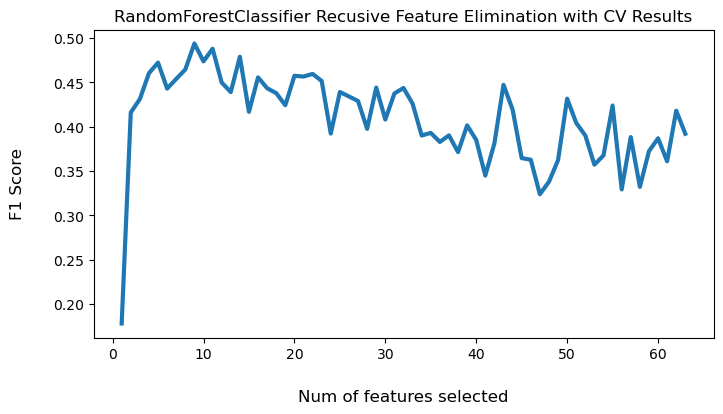

Optimal number of features: 9


,feature,ranking
3,How many days were you hospitalized for your m...,1
4,I am legally disabled,1
8,Total gaps in resume in months,1
9,Annual income (including any social welfare pr...,1
11,Annual income from social welfare programs,1
34,Age_> 60,1
36,Gender_Male,1
61,Device Type_iOS Phone / Tablet,1
62,time_to_complete,1


Re-run the model with only the most importnat features of the same train-test split data used in the previous modeling so we can accurately compare the results.

Accuracy: 0.79
Precision: 0.6
Recall: 0.53
F1: 0.56


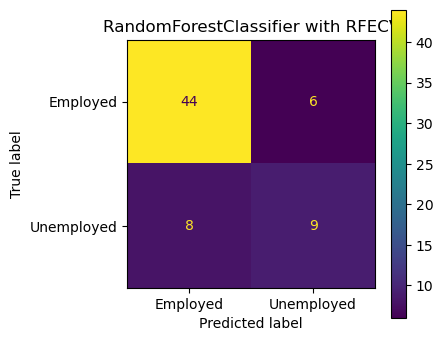

In [24]:
X_most_imp_rand_for = run_rfe(X, y, RandomForestClassifier(random_state=random_seed), base_filename='rand_forest')

#### Notice the engineered feature, "time_to_complete" is one of the most important

### RFECV with Logistic Regression

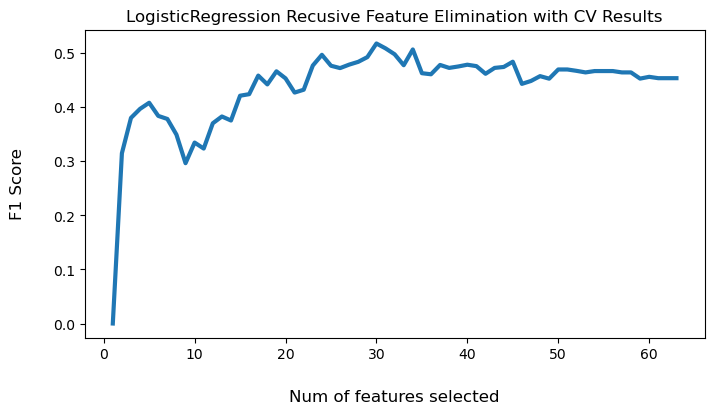

Optimal number of features: 30


,feature,ranking
2,I have been hospitalized before for my mental ...,1
4,I am legally disabled,1
5,I have my regular access to the internet,1
6,I live with my parents,1
8,Total gaps in resume in months,1
9,Annual income (including any social welfare pr...,1
12,I receive food stamps,1
17,Depression,1
18,Obsessive_thinking,1
19,Mood_swings,1


Re-run the model with only the most importnat features of the same train-test split data used in the previous modeling so we can accurately compare the results.

Accuracy: 0.76
Precision: 0.55
Recall: 0.35
F1: 0.43


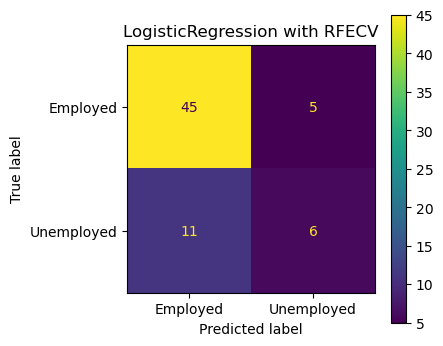

In [25]:
X_most_imp_log_reg = run_rfe(X, y, LogisticRegression(random_state=random_seed), base_filename='logistic_regression', scale_features=True)

### Does Hyperparameter tuning with Gridsearch help the Random Forest?

In [26]:
X_most_imp = X[X_most_imp_rand_for].copy()

In [27]:
# recreating the train test split from the RFECV function
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_most_imp, y, test_size = .2, random_state=random_seed, stratify=y)

In [28]:
pipe_rf_rfe = Pipeline(steps=[
    ## RandomForests/Decision Trees don't benefit from scaling('scaler', StandardScaler()),
    ('estimator', RandomForestClassifier(random_state=random_seed))
])

# define parameter ranges in dict
# use double underscore to link pipline object with param name -
# - use the label created when defining the pipe for the test left of the '__'
params_rf_rfe = {
    'estimator__n_estimators' : np.arange(40, 111, 10),
    'estimator__max_depth' : np.arange(8, 20, 1),
    'estimator__max_features' : ['auto', 'sqrt', 'log2']
}

gridpipe_rf_rfe = tune_model(X_train_rfe, y_train_rfe, pipe_rf_rfe, params_rf_rfe)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   30.3s


Best F1 Score: 0.8870967741935484
{'estimator__max_depth': 9, 'estimator__max_features': 'auto', 'estimator__n_estimators': 80}


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   34.9s finished


Accuracy: 0.76
Precision: 0.54
Recall: 0.41
F1: 0.47


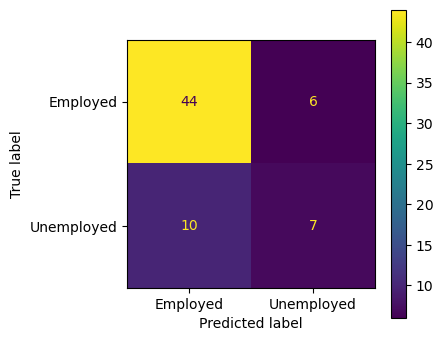

In [29]:
plt.rcParams.update(plt.rcParamsDefault)
score_fitted_model(gridpipe_rf_rfe, X_test_rfe, y_test_rfe, file_name='conf_mat_rfe_gridsearch')

## No, it doesn't improve things

In [30]:
def run_cv_rf(X, y):
    pipe = make_pipeline(RandomForestClassifier())
    skf = StratifiedKFold(n_splits=10, random_state=11, shuffle=True)
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy')
    print(f'Accuracy Scores: {scores}')
    print(f'\tMean:{scores.mean()}')
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='recall')
    print(f'Recall Scores: {scores}')
    print(f'\tMean:{scores.mean()}')
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='f1')
    print(f'F1 Scores: {scores}')
    print(f'\tMean:{scores.mean()}')

run_cv_rf(X, y)

Accuracy Scores: [0.79411765 0.79411765 0.78787879 0.81818182 0.78787879 0.75757576
 0.75757576 0.78787879 0.81818182 0.81818182]
	Mean:0.7921568627450981
Recall Scores: [0.22222222 0.55555556 0.44444444 0.44444444 0.22222222 0.11111111
 0.25       0.         0.375      0.5       ]
	Mean:0.3125
F1 Scores: [0.36363636 0.57142857 0.46153846 0.46153846 0.46153846 0.2
 0.18181818 0.18181818 0.53333333 0.5       ]
	Mean:0.3916650016650016


# Possible Additional Steps
- PCA?
- Oversampling to balance classes?
- Turn buckets into averages instead of OneHotEncoding?